In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import warnings
import math
from math import sqrt
import time
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


## 1. Load consumption data


|Data                |Granularity |Year range|
|--------------------|------------|----------|
|Load consumption    |hourly      |2006-2025 |

In [4]:
# Load the dataset to explore trends and patterns
data_path = 'loadConsumption/data_2006_2025.csv'
data = pd.read_csv(data_path)

# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173107 entries, 0 to 173106
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   loadConsumption  173107 non-null  float64
 1   date             173107 non-null  object 
 2   datetime         173107 non-null  object 
 3   Hour             173107 non-null  int64  
 4   Year             173107 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 6.6+ MB


In [5]:
# Convert 'datetime' to pandas datetime for time-series operations
data['datetime'] = pd.to_datetime(data['datetime'])

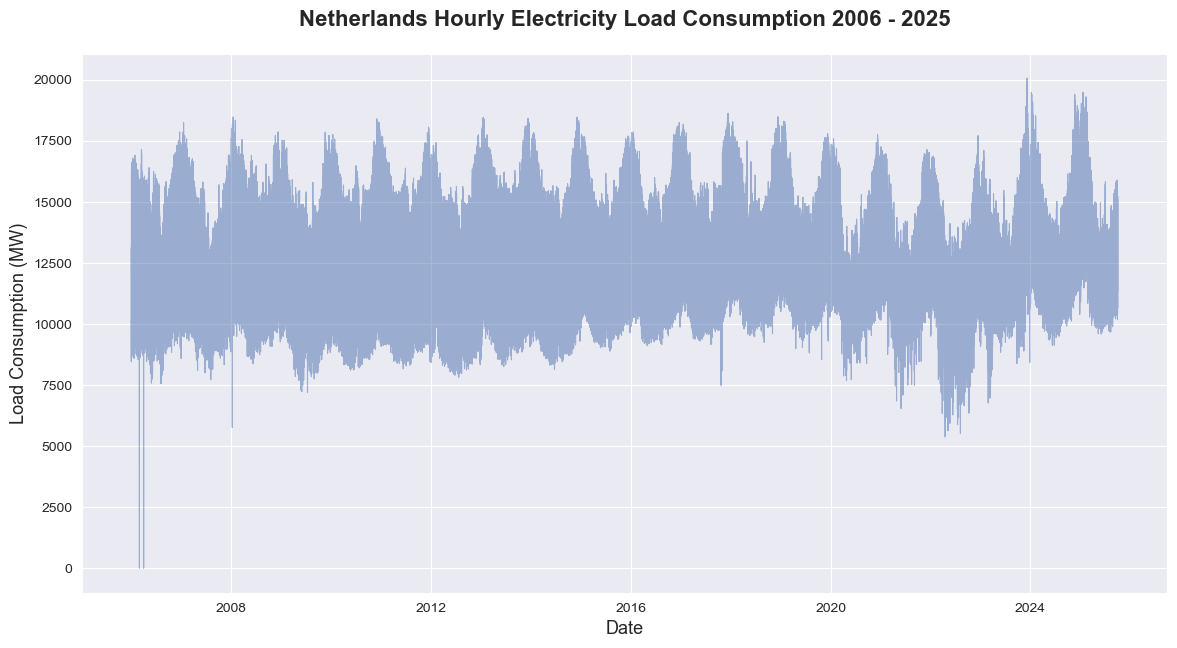

In [36]:
# Set seaborn style
sns.set_style("darkgrid")
sns.set_palette('deep')

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['loadConsumption'], label='Hourly Load Consumption', alpha=0.5, linewidth=0.8)

# Add title and labels
plt.title('Netherlands Hourly Electricity Load Consumption 2006 - 2025', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Load Consumption (MW)', fontsize=13)

plt.savefig("plots/load_consumption_timeseries.png", dpi=300, bbox_inches='tight')

plt.show()

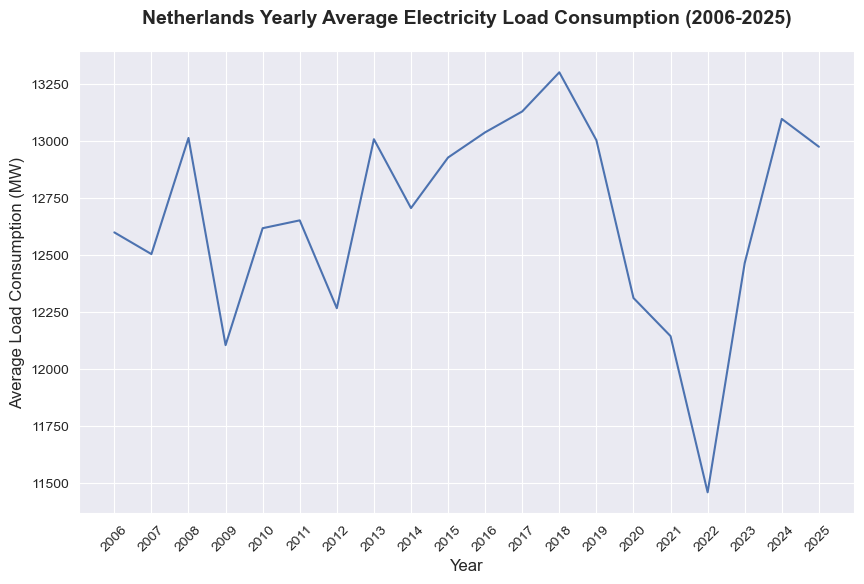

In [37]:
# Aggregate data for yearly trends
yearly_data = data.groupby('Year')['loadConsumption'].mean().reset_index()

# Plot yearly trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_data, x='Year', y='loadConsumption')
plt.title('Netherlands Yearly Average Electricity Load Consumption (2006-2025)', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Load Consumption (MW)', fontsize=12)
plt.xticks(yearly_data['Year'], rotation=45)

plt.savefig("plots/yearly_load_consumption.png", dpi=300, bbox_inches='tight')

plt.show()

The graph shows relatively stable electricity consumption in the Netherlands (2006-2025) with notable drops during the 2009 financial crisis and a dramatic decline in 2022 (lowest at ~11,500 MW), likely due to the COVID-19 pandemic and energy crisis, followed by recovery in 2023-2024.

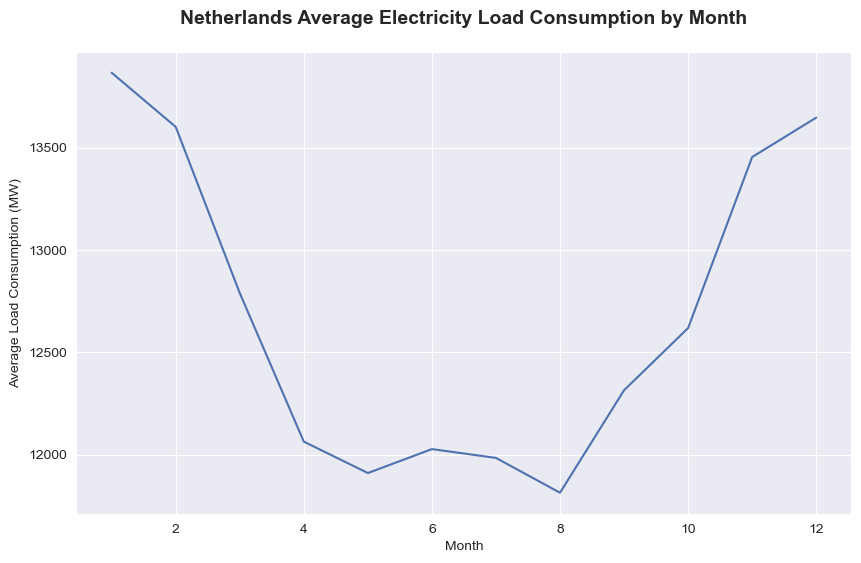

In [38]:
# Monthly patterns by extracting the month
data['Month'] = data['datetime'].dt.month
monthly_data = data.groupby('Month')['loadConsumption'].mean()

# Plot monthly trends
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_data.index, y=monthly_data.values)
plt.title("Netherlands Average Electricity Load Consumption by Month", fontsize=14, pad=20, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Average Load Consumption (MW)")

plt.savefig("plots/avgMonthly_load_consumption.png", dpi=300, bbox_inches='tight')

plt.show()


The monthly pattern shows clear seasonal variation with peak consumption during winter months (December-January at ~13,700 MW) driven by heating demand, and lowest consumption during summer months (May-August at ~12,000 MW) when heating is minimal.

                   mean       median          std
DayOfWeek                                        
Friday     13106.137455  13133.00000  2103.263908
Monday     12973.026212  13128.57125  2286.856835
Saturday   11743.717239  11691.00000  1595.097381
Sunday     11151.423044  11050.05250  1575.456399
Thursday   13239.687707  13388.92750  2186.703218
Tuesday    13194.770018  13341.36875  2170.645381
Wednesday  13231.344341  13361.00000  2185.613771


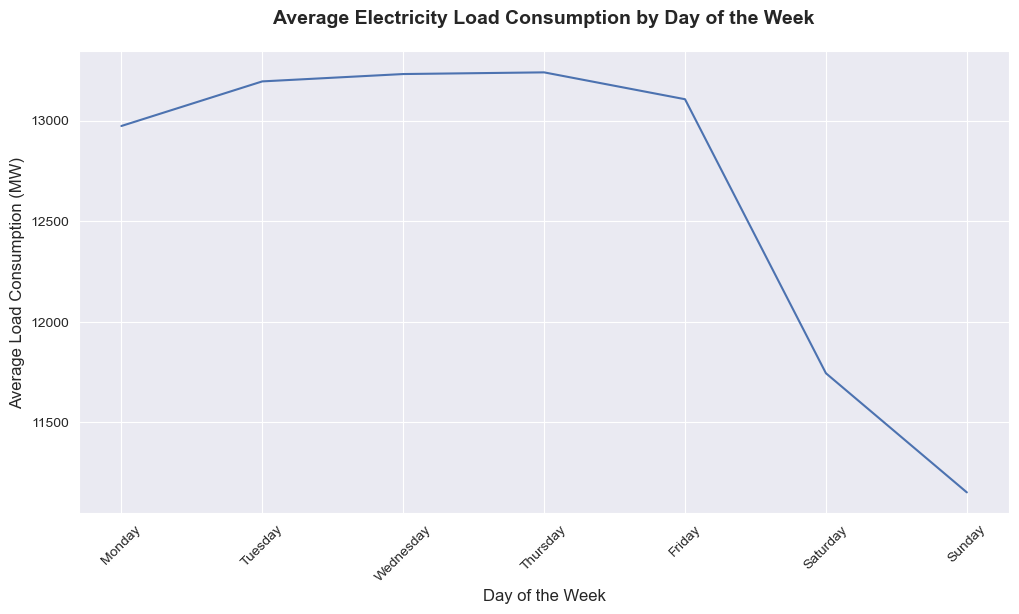

In [51]:
# Create a day of the week column
data['DayOfWeek'] = data['date'].dt.day_name()

# Calculate average consumption per day of week
daily_data = data.groupby('DayOfWeek')['loadConsumption'].agg(['mean', 'median', 'std'])
print(daily_data)

# Define the correct order for days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Visualize with boxplot
daily_mean = data.groupby('DayOfWeek')['loadConsumption'].mean().reindex(day_order)

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(day_order)), y=daily_mean.values)
plt.xticks(range(len(day_order)), day_order, rotation=45)
plt.title('Average Electricity Load Consumption by Day of the Week', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Load Consumption (MW)', fontsize=12)

plt.savefig("plots/daily_consumption_line.png", dpi=300, bbox_inches='tight')
plt.show()

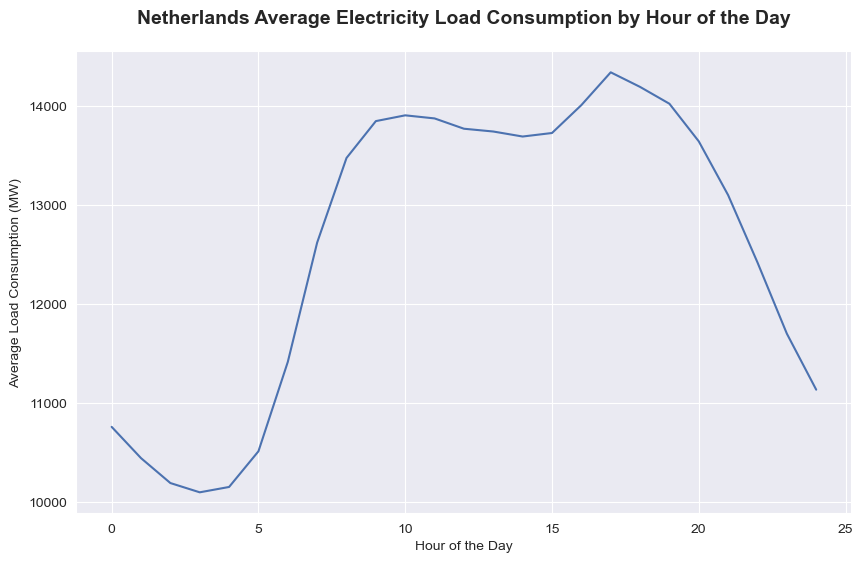

In [39]:
# Hourly patterns
hourly_data = data.groupby('Hour')['loadConsumption'].mean()

# Plot hourly trends
plt.figure(figsize=(10, 6))

sns.lineplot(data=hourly_data.reset_index(), x='Hour', y='loadConsumption')
plt.title("Netherlands Average Electricity Load Consumption by Hour of the Day", fontsize=14, pad=20, fontweight='bold')
plt.xlabel("Hour of the Day")
plt.ylabel("Average Load Consumption (MW)")

plt.savefig("plots/average_hourly_load_consumption.png", dpi=300, bbox_inches='tight')

plt.show()

The hourly pattern shows typical daily electricity demand with lowest consumption during early morning hours (3-4 AM at ~10,100 MW), sharp increases during morning wake-up hours (5-8 AM), sustained high demand throughout the workday (9 AM-6 PM at ~13,900 MW), an evening peak around 6-7 PM (~14,300 MW), and gradual decline through the night as households and businesses wind down.

In [40]:
# Identify outliers using the IQR method
Q1 = data['loadConsumption'].quantile(0.25)
Q3 = data['loadConsumption'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows with outliers
outliers = data[(data['loadConsumption'] < lower_bound) | (data['loadConsumption'] > upper_bound)]

# Display the outliers
outliers

,loadConsumption,date,datetime,Hour,Year,Month
1416,0.0000,2006-03-01,2006-02-28 23:00:00,0,2006,2
2160,0.0000,2006-04-01,2006-03-31 23:00:00,0,2006,3
142808,5443.1750,2022-04-17,2022-04-17 11:00:00,12,2022,4
142809,5383.1850,2022-04-17,2022-04-17 12:00:00,13,2022,4
143312,5644.5375,2022-05-08,2022-05-08 11:00:00,12,2022,5
143313,5632.2950,2022-05-08,2022-05-08 12:00:00,13,2022,5
145496,5528.5600,2022-08-07,2022-08-07 11:00:00,12,2022,8
145497,5533.1850,2022-08-07,2022-08-07 12:00:00,13,2022,8
157188,20059.6425,2023-12-07,2023-12-07 16:00:00,17,2023,12
157189,20019.3050,2023-12-07,2023-12-07 17:00:00,18,2023,12


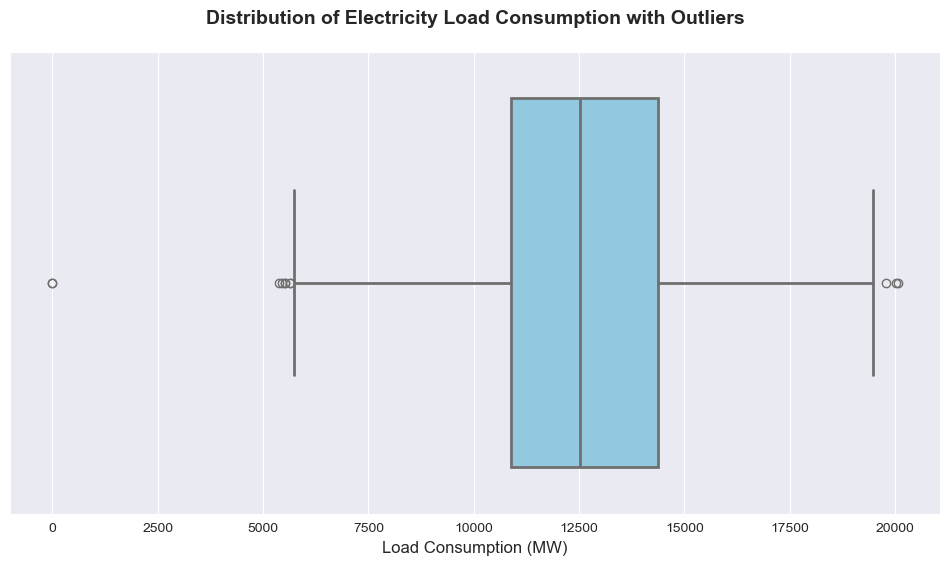

In [42]:
# Check for outliers in the 'loadConsumption' column
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['loadConsumption'], color='skyblue', linewidth=2)
plt.title('Distribution of Electricity Load Consumption with Outliers', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Load Consumption (MW)', fontsize=12)

plt.savefig("plots/load_consumption_boxplot.png", dpi=300, bbox_inches='tight')

plt.show()

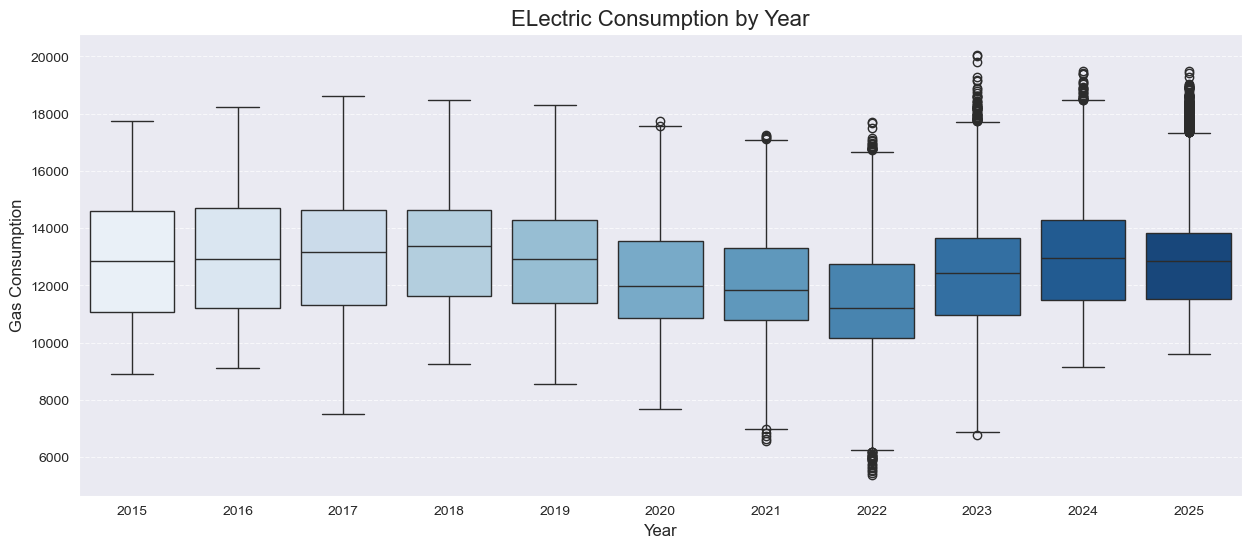

In [43]:
data_filtered = data[data['date'].dt.year >= 2015]

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=data_filtered, x='Year', y='loadConsumption', palette='Blues')
ax.set_title('ELectric Consumption by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Gas Consumption', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("plots/ElecConsYear.png", dpi=300, bbox_inches='tight')

plt.show()

In [44]:
# Assign seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

# Create a season column
data['Season'] = data['date'].dt.month.map(get_season)  

data.head()

,loadConsumption,date,datetime,Hour,Year,Month,Season
0,10215.0,2006-01-01,2005-12-31 23:00:00,0,2006,12,Winter
1,9979.0,2006-01-01,2006-01-01 00:00:00,1,2006,1,Winter
2,9460.0,2006-01-01,2006-01-01 01:00:00,2,2006,1,Winter
3,8833.0,2006-01-01,2006-01-01 02:00:00,3,2006,1,Winter
4,8525.0,2006-01-01,2006-01-01 03:00:00,4,2006,1,Winter


                mean      median          std       min         max
Season                                                             
Fall    12786.182186  12800.0000  2135.181452  6355.775  19383.0000
Spring  12256.820170  12121.9025  1997.879965     0.000  17547.0000
Summer  11941.153737  11845.0000  1779.569416  5528.560  16688.0000
Winter  13710.085823  13781.0000  2362.329155  5767.000  20059.6425


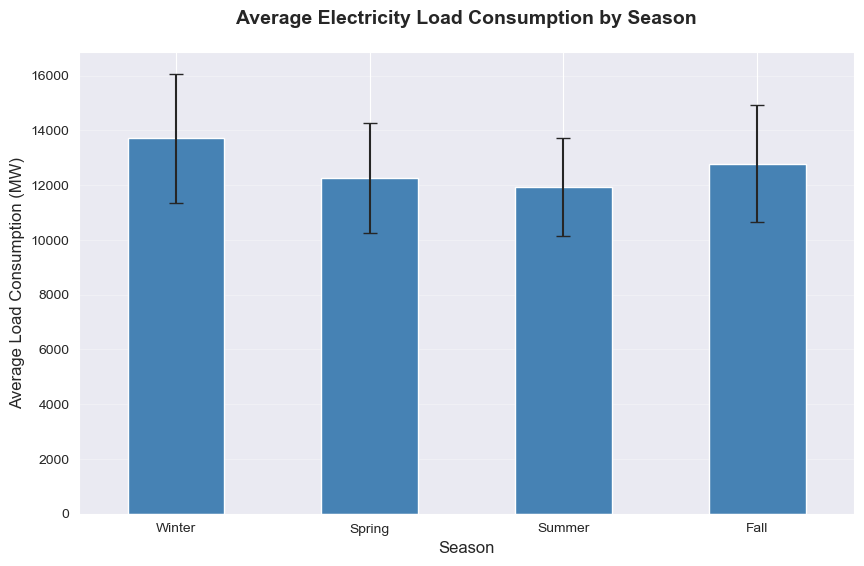

In [46]:
# Calculate average consumption per season
seasonal_data = data.groupby('Season')['loadConsumption'].agg(['mean', 'median', 'std', 'min', 'max'])
print(seasonal_data)

# Alternative: Bar plot with error bars
seasonal_mean = data.groupby('Season')['loadConsumption'].mean()
seasonal_std = data.groupby('Season')['loadConsumption'].std()

plt.figure(figsize=(10, 6))
seasonal_mean.reindex(['Winter', 'Spring', 'Summer', 'Fall']).plot(kind='bar', 
                                                                      color='steelblue', 
                                                                      yerr=seasonal_std.reindex(['Winter', 'Spring', 'Summer', 'Fall']),
                                                                      capsize=5)
plt.title('Average Electricity Load Consumption by Season', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Load Consumption (MW)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.savefig("plots/seasonal_consumption_barplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [55]:
import statsmodels.api as sm
from scipy.stats import shapiro

def check_normality(df, feature):
    plt.figure(figsize=(6, 6))

    # histogram
    plt.hist(df[feature], edgecolor='black', bins=20)
    plt.title(f'Histogram of {feature}')

    # qq plot
    sm.qqplot(df[feature], line='45')
    plt.title(f'QQ plot of {feature}')

    plt.tight_layout()

    plt.show()

    # shapiro wilk
    print(shapiro(df[feature]))


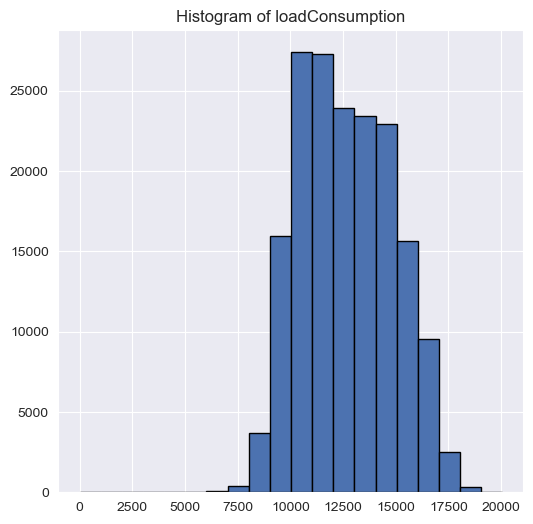

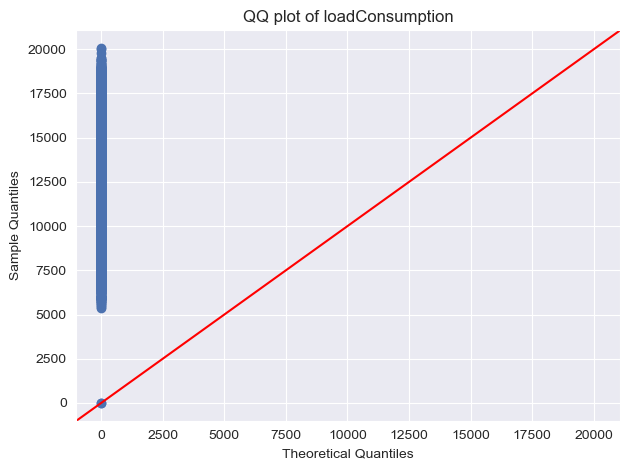

ShapiroResult(statistic=np.float64(0.9825384040199782), pvalue=np.float64(1.3558008370023883e-78))


In [56]:
check_normality(df=data, feature='loadConsumption')

The Shapiro-Wilk test (p-value≈0) confirms that electricity load consumption is not normally distributed, which is also confirmed from the QQ-plot.